<a href="https://colab.research.google.com/github/pranchalkumar001/leukemia-detection-model/blob/main/leukemia_detection_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/mehradaria/leukemia')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pranchalkumar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mehradaria/leukemia


100%|██████████| 110M/110M [00:00<00:00, 1.18GB/s]

In [3]:
!nvidia-smi

Sat Sep  6 12:28:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


In [5]:
train_dir = "/content/leukemia/Segmented"

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [7]:
# Load pretrained VGG16 without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False   # freeze feature extractor

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(4, activation="softmax")(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 677ms/step - accuracy: 0.3738 - loss: 1.3282 - val_accuracy: 0.6163 - val_loss: 1.1036
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 500ms/step - accuracy: 0.7119 - loss: 0.9302 - val_accuracy: 0.6718 - val_loss: 0.9834
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 513ms/step - accuracy: 0.7799 - loss: 0.7703 - val_accuracy: 0.6687 - val_loss: 0.9148
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.7980 - loss: 0.6728 - val_accuracy: 0.6718 - val_loss: 0.8787
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 536ms/step - accuracy: 0.8062 - loss: 0.6134 - val_accuracy: 0.7119 - val_loss: 0.8282
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 506ms/step - accuracy: 0.8421 - loss: 0.5517 - val_accuracy: 0.7119 - val_loss: 0.8137
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 521ms/step - accuracy: 0.8345 - loss: 0.5207 - val_accuracy: 0.7227 - val_loss: 0.7901
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 502ms/step - accuracy: 0.8537 - loss: 0.4836 - val_accu

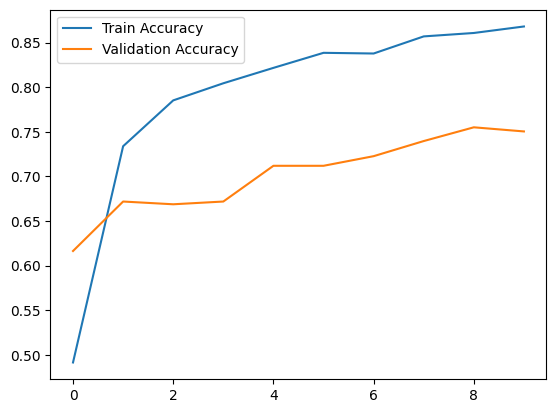

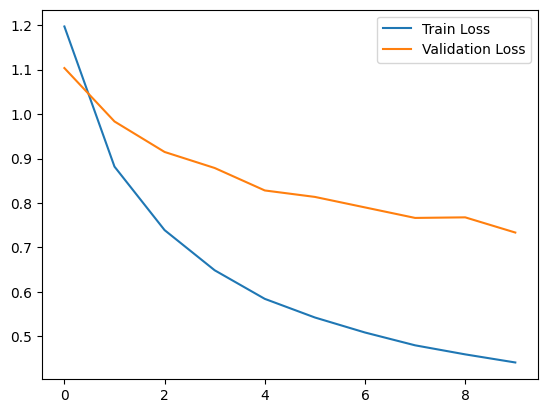

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [10]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 396ms/step - accuracy: 0.7552 - loss: 0.7262
Validation Accuracy: 74.73%


In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to one test image
img_path = "/content/leukemia/Segmented/Early/WBC-Malignant-Early-001.jpg" #now i take a image from Early dataset, for check it work or not

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
class_labels = list(train_gen.class_indices.keys())
print("Predicted Class:", class_labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Early


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions for validation set
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step
Confusion Matrix:
 [[ 7 29 16 48]
 [19 78 31 69]
 [24 78 27 63]
 [14 69 28 49]]
              precision    recall  f1-score   support

      Benign       0.11      0.07      0.09       100
       Early       0.31      0.40      0.35       197
         Pre       0.26      0.14      0.18       192
         Pro       0.21      0.31      0.25       160

    accuracy                           0.25       649
   macro avg       0.22      0.23      0.22       649
weighted avg       0.24      0.25      0.23       649

